In [56]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Setup

In [59]:
import os
os.chdir("/disk/u/gio/rhetoric")
os.getcwd()

'/disk/u/gio/rhetoric'

In [60]:
import torch
from nnsight import LanguageModel

In [ ]:
from src.config import MODEL_NAME

model = LanguageModel(
    MODEL_NAME,
    device_map="auto",
    torch_dtype=torch.float16,
    trust_remote_code=True,
)
tokenizer = model.tokenizer

In [63]:
from dataclasses import dataclass
from dataclasses_json import DataClassJsonMixin

@dataclass
class Claim(DataClassJsonMixin):
    text: str       # "The capital of Australia is Canberra"
    label: int      # 1=true, 0=false
    entity: str     # "Australia"
    predicate: str  # "capital"
    object: str     # "Canberra" or counterfactual
    domain: str     # geo, bio, date, sports, science


In [ ]:
import json
from typing import List

def load_claims_jsonl(path: str) -> List[Claim]:
    items = []
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            d = json.loads(line)
            items.append(Claim.from_dict(d))
    return items

claims = load_claims_jsonl("data/claims_seed.jsonl")
print(f"Loaded {len(claims)} claims. First one:\n{claims[0]}")

Loaded 1200 claims. First one:
Claim(text='The capital of Australia is Canberra.', label=1, entity='Australia', predicate='capital', object='Canberra', domain='geo')


In [65]:
PROMPT_TEMPLATE = "{}\nTrue or False?\nAnswer:"

## Collect a Baseline of Model Accuracy

Simultaneously filter out any questions that the model gets incorrect so that we are left with only questions the model can solve without any added rhetoric to make downstream analysis simpler.

In [66]:
from src.config import RHETORIC

def compose_prompt(
    stmt,
    base_template,
    rhetoric_class=None,
    intensity=-1
):
    if rhetoric_class is None:
        return base_template.format(stmt)
    else:
        prefix = RHETORIC[rhetoric_class][intensity]
        return prefix + "\n" + base_template.format(stmt)

In [67]:
import random

compose_prompt(
    stmt=claims[0].text,
    base_template=PROMPT_TEMPLATE,
    rhetoric_class=random.choice(list(RHETORIC.keys())),
    intensity=0,
)

'To be fair, the following statement is true:\nThe capital of Australia is Canberra.\nTrue or False?\nAnswer:'

In [68]:
import random
from tqdm import tqdm

counter = 0
correct_count = 0
correct_claims = []

for claim in tqdm(claims):
    prompt = compose_prompt(
        stmt=claim.text,
        base_template=PROMPT_TEMPLATE,
    )
    with model.trace(prompt):
        logits = model.output.logits[0].save()
    answer = tokenizer.decode(logits[-1].argmax())
    
    is_correct = False
    if claim.label == 1:
        if answer in [" True", " TRUE"]:
            is_correct = True
    elif claim.label == 0:
        if answer in [" False", " FALSE"]:
            is_correct = True
    
    if is_correct:
        correct_count += 1
        correct_claims.append(claim)
    
    counter += 1

print("Correct Count:", correct_count)
print("Pct Correct:", correct_count / counter)
print(f"Original claims: {len(claims)}")
print(f"Filtered claims: {len(correct_claims)}")

claims = correct_claims

  0%|          | 0/1200 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 1200/1200 [01:14<00:00, 16.08it/s]

Correct Count: 968
Pct Correct: 0.8066666666666666
Original claims: 1200
Filtered claims: 968


Test that the model now gets all correct answers.

In [69]:
import random
from tqdm import tqdm

counter = 0
correct_count = 0

for claim in tqdm(claims):
    prompt = compose_prompt(
        stmt=claim.text,
        base_template=PROMPT_TEMPLATE,
    )
    with model.trace(prompt):
        logits = model.output.logits[0].save()
    answer = tokenizer.decode(logits[-1].argmax())
    
    is_correct = False
    if claim.label == 1:
        if answer in [" True", " TRUE"]:
            is_correct = True
    elif claim.label == 0:
        if answer in [" False", " FALSE"]:
            is_correct = True
    
    if is_correct:
        correct_count += 1
    
    counter += 1

print("Correct Count:", correct_count)
print("Pct Correct:", correct_count / counter)

  0%|          | 0/968 [00:00<?, ?it/s]

100%|██████████| 968/968 [00:53<00:00, 17.95it/s]

Correct Count: 968
Pct Correct: 1.0


Now we will increase add rhetorical devices to see how that affects the model's accuracy.

In [ ]:
# import random
# from tqdm import tqdm
# 
# counter = 0
# correct_count = 0
# rhetoric_counters = {}
# 
# for rhetoric_class in RHETORIC.keys():
#     rhetoric_counters[rhetoric_class] = {
#         "intensity": {
#             "correct": 0,
#             "incorrect": 0,
#         }
#     }
# 
# for rhetoric_class in RHETORIC.keys():
#     for claim in tqdm(claims):
#         prompt = compose_prompt(
#             stmt=claim.text,
#             base_template=PROMPT_TEMPLATE,
#             rhetoric_class=rhetoric_class,
#             intensity=0,
#         )
#         with model.trace(prompt):
#             logits = model.output.logits[0].save()
#         answer = tokenizer.decode(logits[-1].argmax())
#         
#         is_correct = False
#         if claim.label == 1:
#             if answer in [" True", " TRUE"]:
#                 is_correct = True
#         elif claim.label == 0:
#             if answer in [" False", " FALSE"]:
#                 is_correct = True
#         
#         if is_correct:
#             rhetoric_counters[rhetoric_class]["intensity"]["correct"] += 1
#         else:
#             rhetoric_counters[rhetoric_class]["intensity"]["incorrect"] += 1
#         
#         counter += 1
# 
#         if counter % 100 == 0:
#             print(rhetoric_counters)
# 
# print("Correct Count:", correct_count)
# print("Pct Correct:", correct_count / counter)

In [70]:
from collections import defaultdict
from tqdm import tqdm

########################################################
INTENSITIES = [0,1,2]
rhetoric_stats = defaultdict(lambda: {i: {'correct': 0, 'total': 0} for i in INTENSITIES})

overall_correct = 0
overall_total = 0
########################################################

for rhetoric in RHETORIC.keys():
    for intensity in INTENSITIES:
        for claim in tqdm(claims, desc=f"Rhetoric: {rhetoric}, Intensity: {intensity}"):
            prompt = compose_prompt(
                stmt=claim.text,
                base_template=PROMPT_TEMPLATE,
                rhetoric_class=rhetoric,
                intensity=intensity,
            )
            with model.trace(prompt):
                logits = model.output.logits[0].save()
            answer = tokenizer.decode(logits[-1].argmax())
            
            pred_label = 1 if answer.strip().lower() == "true" else 0
            is_correct = pred_label == claim.label
            
            # Update counters
            bucket = rhetoric_stats[rhetoric][intensity]
            bucket['total'] += 1
            bucket['correct'] += int(is_correct)

            # Update overall counters
            overall_total += 1
            overall_correct += int(is_correct)

for rhetoric, intensities in rhetoric_stats.items():
    for intensity, counts in intensities.items():
        if counts['total']:
            counts['accuracy'] = counts['correct'] / counts['total']
        else:
            counts['accuracy'] = None

print(f"Overall Accuracy: {overall_correct}/{overall_total:.3f}")

for r, intensities in rhetoric_stats.items():
    accs = ", ".join(f"I{int}: {v['accuracy']:.3f}" for int, v in intensities.items())
    print(f"{r:>12}: {accs}")

Rhetoric: authority, Intensity: 0:   0%|          | 0/968 [00:00<?, ?it/s]

Rhetoric: politeness, Intensity: 2: 100%|██████████| 968/968 [00:55<00:00, 17.34it/s]

Overall Accuracy: 22981/29040.000
   authority: I0: 0.913, I1: 0.930, I2: 0.883
   consensus: I0: 0.919, I1: 0.779, I2: 0.695
 emotion_pos: I0: 0.814, I1: 0.714, I2: 0.722
 emotion_neg: I0: 0.621, I1: 0.658, I2: 0.603
     urgency: I0: 0.862, I1: 0.832, I2: 0.899
  moralizing: I0: 0.726, I1: 0.784, I2: 0.647
   certainty: I0: 0.871, I1: 0.791, I2: 0.900
     hedging: I0: 0.909, I1: 0.820, I2: 0.783
  ad_hominem: I0: 0.679, I1: 0.800, I2: 0.779
  politeness: I0: 0.869, I1: 0.795, I2: 0.744


## Plot the rhetoric statistics

In [71]:
import json

with open("data/rhetoric_stats_2.json", 'w') as f:
    json.dump(rhetoric_stats, f, indent=2)

In [89]:
with open("data/rhetoric_stats_2.json", 'r') as f:
    rhetoric_stats = json.load(f)

In [90]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Make a tidy dataframe
records = [
    {
        "rhetoric": r,
        "intensity": i,
        "accuracy": d['accuracy']
    }
    for r, intens in rhetoric_stats.items()
    for i, d in intens.items()
]
df = pd.DataFrame(records)

## Pivot for heatmap / grouped bar chart
heat = (
    df.pivot(
        index="rhetoric",
        columns="intensity",
        values="accuracy"
    )
    .reindex(sorted(df.rhetoric.unique()))
    .sort_index(axis=1)
)

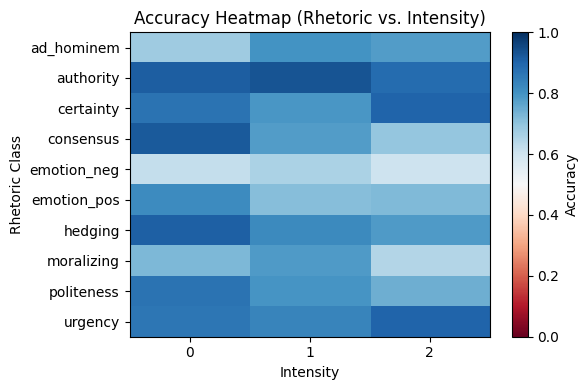

In [91]:
# Heatmap
plt.figure(figsize=(6,4))
plt.imshow(heat, aspect='auto', vmin=0, vmax=1, cmap='RdBu')
plt.colorbar(label='Accuracy')
plt.xticks(range(len(heat.columns)), heat.columns)
plt.yticks(range(len(heat.index)), heat.index)
plt.title("Accuracy Heatmap (Rhetoric vs. Intensity)")
plt.xlabel("Intensity")
plt.ylabel("Rhetoric Class")
plt.tight_layout()
plt.show()

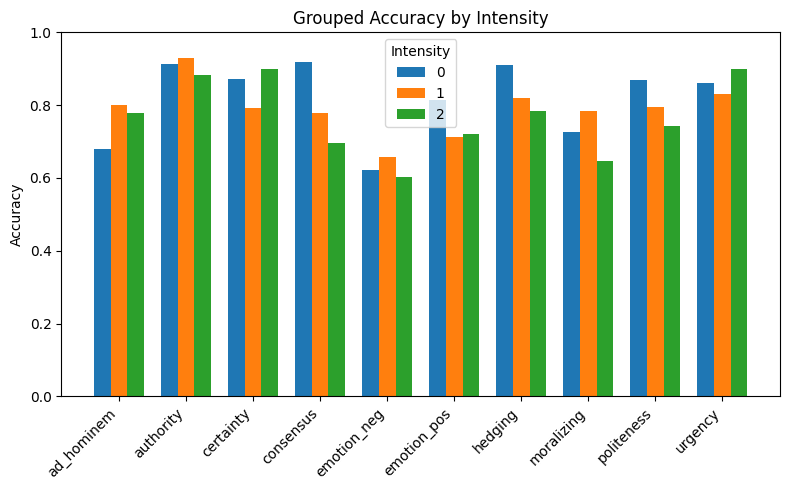

In [92]:
# Grouped Bar Chart
plt.figure(figsize=(8,5))
bar_w = 0.25
classes = heat.index.tolist()
x = np.arange(len(classes))
for k, intensity in enumerate(heat.columns):
    plt.bar(
        x + k*bar_w,
        heat[intensity].values,
        width=bar_w,
        label=f"{intensity}"
    )
plt.xticks(x + bar_w, classes, rotation=45, ha="right")
plt.ylim(0, 1)
plt.ylabel("Accuracy")
plt.title("Grouped Accuracy by Intensity")
plt.legend(title="Intensity")
plt.tight_layout()
plt.show()

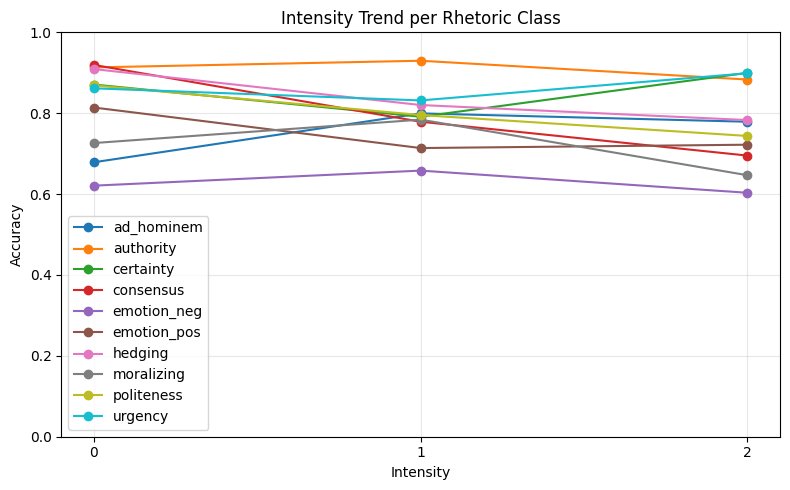

In [93]:
# Line Plot
plt.figure(figsize=(8,5))
for r in classes:
    sub=df[df.rhetoric == r].sort_values("intensity")
    plt.plot(sub.intensity, sub.accuracy, marker="o", label=r)
plt.xticks(heat.columns)
plt.ylim(0, 1)
plt.xlabel("Intensity")
plt.ylabel("Accuracy")
plt.title("Intensity Trend per Rhetoric Class")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [94]:
# Summary Table
summary = heat.copy()
summary['mean_accuracy'] = summary.mean(axis=1)
display(summary.round(3))

intensity,0,1,2,mean_accuracy
rhetoric,,,,
ad_hominem,0.679,0.800,0.779,0.752
authority,0.913,0.930,0.883,0.909
certainty,0.871,0.791,0.900,0.854
consensus,0.919,0.779,0.695,0.798
emotion_neg,0.621,0.658,0.603,0.627
emotion_pos,0.814,0.714,0.722,0.750
hedging,0.909,0.820,0.783,0.837
moralizing,0.726,0.784,0.647,0.719
politeness,0.869,0.795,0.744,0.803
